## Examine the elasticity of the residential location choice model

In [1]:
# Load data
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import set_seed, train, evaluate_nn, Config, get_elasticity, get_cross_elasticity
from models import MNL_Choice, SCL_Choice, GNNChoiceModel, MLP_Choice
from data_process import load_data, spatial_choice_dataset_interact
comm, hh, edge_index, distance_to_work = load_data()

comm_features = [
    "pop_density",
    "white_prop",
    "black_prop",
    "single_res",
    "multi_res",
    "office",
    "retail",
    "land_mix",
    "transit_a_scaled",
    "med_house_age_scaled",
    "med_value_scaled",
    "h_units_scaled",
    "median_inc_scaled",
]

hh_features = ["hh_income_scaled", "race_white", "race_black"]

# Load dataset
my_dataset = spatial_choice_dataset_interact

i = 0
test_idx = np.arange(i, len(hh), 10)
train_idx = np.setdiff1d(np.arange(len(hh)), test_idx)
train_dataset = my_dataset(
    comm, hh.loc[train_idx, :], distance_to_work[train_idx], comm_features, hh_features
)
test_dataset = my_dataset(
    comm, hh.loc[test_idx, :], distance_to_work[test_idx], comm_features, hh_features
)

In [2]:
# Load GNN model
device = torch.device("cpu")
config = Config()
config.bs = 32
config.num_hidden = 64
config.dropout = 0
config.model = "GATConv"
config.heads = 4  # Number of attention heads for GAT
config.residual = True
config.seed = 100

gnn1 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=1,
)
gnn1.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-02-25_22-44-08.pth"))


gnn2 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=2,
)
gnn2.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-02-25_22-26-26.pth"))


gnn3 = GNNChoiceModel(
    train_dataset[0][0].shape[-1],
    config.num_hidden,
    edge_index,
    dropout=config.dropout,
    heads=config.heads,
    residual=config.residual,
    n_layer=3,
)
gnn3.load_state_dict(torch.load("log/Deepchoice_GATConv_2025-02-25_22-49-33.pth"))

# Load MLP model
config.num_hidden = 64
config.model = "MLP"
mlp = MLP_Choice(train_dataset[0][0].shape[-1], config.num_hidden, config.dropout)
mlp.load_state_dict(torch.load("log/Deepchoice_MLP_2025-02-17_14-38-30.pth"))

# Load MNL model
mnl = MNL_Choice(train_dataset[0][0].shape[-1],
                    train_dataset[0][0].shape[0]).to(device)
mnl.load_state_dict(torch.load("log/Deepchoice_MNL_2025-02-17_14-40-37.pth"))


/var/folders/v6/5jphmjb1409bj0_xw7mj_7dc0000gn/T/ipykernel_52065/4028631678.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gnn1.load_state_dict(torch.load("log/Deepcho

<All keys matched successfully>

## Calculate the Elasticity

In [3]:
# Calculate the elasticities of the models
n = 10  # The index of an individual in the test data
i = 5  # The index of the alternative in the choice set
x = test_dataset[n][0]
elasticity_dict = {}
elasticity_dict['GNN'] = get_elasticity(gnn2, x, i).detach().numpy()
elasticity_dict['MLP'] = get_elasticity(mlp, x, i).detach().numpy()
elasticity_dict['MNL'] = get_elasticity(mnl, x, i).detach().numpy()
elasticity = pd.DataFrame(elasticity_dict, index=train_dataset.feature_names)
elasticity.head(14)


,GNN,MLP,MNL
pop_density,0.504007,0.720151,2.495218
single_res,-0.044016,-0.025251,-0.056611
multi_res,0.265150,0.215383,0.093593
office,-0.003696,-0.011170,0.000187
retail,-0.085517,-0.421334,-0.112094
land_mix,0.130927,0.516093,-1.018175
transit_a_scaled,0.085724,0.202630,-0.229894
med_house_age_scaled,0.994750,1.357030,0.755853
med_value_scaled,-0.644419,-1.530105,0.840422
h_units_scaled,0.691099,1.185541,0.834052


In [36]:
elasticity.to_clipboard()

## Calculate the cross-elasticities

In [38]:
# Calculate the cross-elasticities of the models
n = 10  # The index of an individual in the test data
i = [2, 4, 6, 27]  # The index of the alternative in the choice set
j = 5
x = test_dataset[n][0]
elasticity_results = {}

for ii in i:
    elasticity_dict = {}
    elasticity_dict["GNN"] = get_cross_elasticity(gnn, x, ii, j).detach().numpy()
    elasticity_dict["MLP"] = get_cross_elasticity(mlp, x, ii, j).detach().numpy()
    elasticity_dict["MNL"] = get_cross_elasticity(mnl, x, ii, j).detach().numpy()
    elasticity_results[ii] = pd.DataFrame(elasticity_dict, index=train_dataset.feature_names)


In [40]:
elasticity_results[2]

,GNN,MLP,MNL
pop_density,0.264322,-0.170026,-0.488672
single_res,-0.031958,0.005962,0.011087
multi_res,-0.025726,-0.050851,-0.018329
office,0.001207,0.002637,-0.000037
retail,-0.064365,0.099476,0.021953
land_mix,-0.151006,-0.121848,0.199403
transit_a_scaled,-0.217425,-0.047841,0.045023
med_house_age_scaled,-0.487130,-0.320392,-0.148029
med_value_scaled,-0.081990,0.361254,-0.164591
h_units_scaled,-0.442580,-0.279904,-0.163344


In [41]:
elasticity_results[2].to_clipboard()

In [42]:
elasticity_results[4]

,GNN,MLP,MNL
pop_density,0.236118,-0.170026,-0.488672
single_res,0.001147,0.005962,0.011087
multi_res,0.048526,-0.050851,-0.018329
office,0.000364,0.002637,-0.000037
retail,0.002425,0.099476,0.021953
land_mix,-0.061372,-0.121848,0.199403
transit_a_scaled,-0.096027,-0.047841,0.045023
med_house_age_scaled,0.010095,-0.320392,-0.148029
med_value_scaled,-0.004680,0.361254,-0.164591
h_units_scaled,-0.093900,-0.279904,-0.163344


In [43]:
elasticity_results[27]

,GNN,MLP,MNL
pop_density,-0.187731,-0.170026,-0.488672
single_res,-0.008226,0.005962,0.011087
multi_res,-0.039134,-0.050851,-0.018329
office,0.000686,0.002637,-0.000037
retail,0.018879,0.099476,0.021953
land_mix,-0.085695,-0.121848,0.199403
transit_a_scaled,-0.054952,-0.047841,0.045023
med_house_age_scaled,-0.226500,-0.320392,-0.148029
med_value_scaled,0.076768,0.361254,-0.164591
h_units_scaled,-0.154089,-0.279904,-0.163344


In [44]:
elasticity_results[27].to_clipboard()

## Visualize the percentage change

In [45]:
train_dataset.feature_names

['pop_density',
 'single_res',
 'multi_res',
 'office',
 'retail',
 'land_mix',
 'transit_a_scaled',
 'med_house_age_scaled',
 'med_value_scaled',
 'h_units_scaled',
 'distance_to_work',
 'home_income_interact',
 'white_interact',
 'black_interact']

In [4]:
def plot_elasticity(model, comm_id, hh_id, percent_change, feature):
    feature_idx = train_dataset.feature_names.index(feature)
    x = test_dataset[hh_id][0].unsqueeze(0)
    p_old = model(x).exp().detach().numpy()

    x_new = x.clone()
    x_new[0, comm_id, feature_idx] = x_new[0, comm_id, feature_idx] * (1 + percent_change)
    p_new = model(x_new).exp().detach().numpy()
    p_change = (p_new - p_old) / p_old
    comm.loc[:, 'p_change'] = p_change.ravel()

    fig, ax = plt.subplots(figsize=(4, 5))
    vmax = np.abs(comm["p_change"]).max()
    a = comm.plot(
        ax=ax,
        column="p_change",
        cmap="RdBu",
        edgecolor="Gray",
        linewidth=0.5,
        legend=False,
        k=8,
        vmin=-vmax,
        vmax=vmax,
    )

    for idx, row in comm.iterrows():
        centroid = row.geometry.centroid
        label = "{:.1%}".format(comm.at[idx, "p_change"])
        # add text as percentage
        plt.text(centroid.x, centroid.y, label, fontsize=5, ha="center", va="center")

    # Remove all axes
    ax.axis("off")
    plt.show()
    return p_change


In [56]:
%matplotlib inline

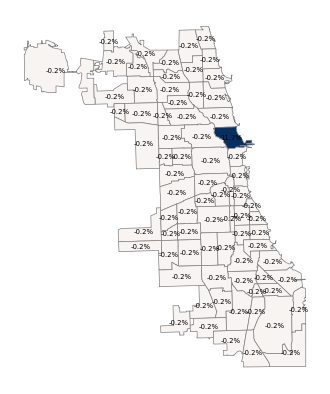

In [57]:
p_change = plot_elasticity(mnl, comm_id=7, hh_id=10, percent_change=0.1, feature="med_value_scaled")

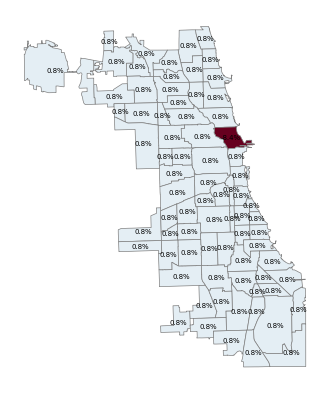

In [58]:
p_change = plot_elasticity(
    mlp, comm_id=7, hh_id=12, percent_change=0.1, feature="med_value_scaled"
)


In [71]:
p_change = plot_elasticity(
    gnn1, comm_id=7, hh_id=10, percent_change=0.1, feature="med_value_scaled"
)


In [70]:
p_change = plot_elasticity(
    gnn2, comm_id=7, hh_id=12, percent_change=0.1, feature="med_value_scaled"
)


In [64]:
p_change = plot_elasticity(
    gnn3, comm_id=7, hh_id=12, percent_change=0.1, feature="med_value_scaled"
)
